# TRANSFER LEARNING USING VGG16

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras.callbacks import CSVLogger

# building model
from tensorflow.keras import backend as K
from tensorflow.keras import layers
from tensorflow.keras import models

# evaluation
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score

from tensorflow.keras.preprocessing.image import ImageDataGenerator

# we use this library in order to get the classes straight from folders without having
# to manually iterate through them


In [4]:
from tensorflow.keras.applications import VGG16

conv_base=VGG16(weights='imagenet', include_top=False,input_shape=(150,150,3))


In [3]:
conv_base.summary()
# this is the conv base included with VGG16

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0     

In [4]:
# creating the model
model=models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(22,activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dense (Dense)               (None, 256)               2097408   
                                                                 
 dense_1 (Dense)             (None, 22)                5654      
                                                                 
Total params: 16,817,750
Trainable params: 16,817,750
Non-trainable params: 0
_________________________________________________________________


In [5]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [5]:
testDir=r"S:\Research Project 2022\Diseased_Data_CNN_Split\test"
trainDir=r"S:\Research Project 2022\Diseased_Data_CNN_Split\train"
validDir=r"S:\Research Project 2022\Diseased_Data_CNN_Split\val"

# TRYING RGB FEATURES


DATA
______

1. The log of train accuracy, train loss, validation accuracy, validation loss can be found in [this log file](./Health_Diseased_Results/transfer%20learning/train_test_valid_tl_rotation_HD.log) 

2. The best model can be loaded from [this model file](./Health_Diseased_Results/transfer%20learning/best_train_test_valid_tl_rot_HD.h5) 

3. The test results for the best model can be found in [this text file](./Health_Diseased_Results/transfer%20learning/train_test_valid_tl_rotation_HD.log) 


In [6]:

all_data_gen=ImageDataGenerator(rescale=1./155)

# we rescale our rgb values to float values

img_height=150
img_width= 150
batch_size=2
train_gen=all_data_gen.flow_from_directory(trainDir,target_size=(img_height, img_width), batch_size=6, class_mode='categorical')
valid_gen=all_data_gen.flow_from_directory(validDir,target_size=(img_height, img_width), batch_size=11, class_mode='categorical')
test_gen=all_data_gen.flow_from_directory(testDir,target_size=(img_height, img_width), batch_size=4, class_mode='categorical')


Found 3594 images belonging to 22 classes.
Found 440 images belonging to 22 classes.
Found 468 images belonging to 22 classes.


In [14]:
# save the best model only
earlyStopping=keras.callbacks.EarlyStopping(monitor='val_loss', patience=2)
checkpt=keras.callbacks.ModelCheckpoint("./Health_Diseased_Results/transfer learning/best_train_test_valid_tl_rot_HD.h5", monitor='val_loss', save_best_only=True)
csv_logger = CSVLogger('./Health_Diseased_Results/transfer learning/train_test_valid_tl_rotation_HD.log', separator=',', append=True)

In [15]:
history=model.fit(train_gen, steps_per_epoch=599, epochs=20, validation_data=valid_gen, validation_steps=40, callbacks=[csv_logger,earlyStopping,checkpt])

Epoch 1/20
599/599 [==============================] - 1544s 3s/step - loss: 3.0668 - accuracy: 0.0701 - val_loss: 3.0214 - val_accuracy: 0.0773
Epoch 2/20
599/599 [==============================] - 1543s 3s/step - loss: 3.0231 - accuracy: 0.0748 - val_loss: 3.0151 - val_accuracy: 0.0773
Epoch 3/20
599/599 [==============================] - 1490s 2s/step - loss: 3.0219 - accuracy: 0.0721 - val_loss: 3.0148 - val_accuracy: 0.0773
Epoch 4/20
599/599 [==============================] - 1518s 3s/step - loss: 3.0219 - accuracy: 0.0732 - val_loss: 3.0148 - val_accuracy: 0.0773
Epoch 5/20
599/599 [==============================] - 1579s 3s/step - loss: 3.0214 - accuracy: 0.0768 - val_loss: 3.0148 - val_accuracy: 0.0727
Epoch 6/20
599/599 [==============================] - 1548s 3s/step - loss: 3.0225 - accuracy: 0.0729 - val_loss: 3.0138 - val_accuracy: 0.0773
Epoch 7/20
599/599 [==============================] - 1664s 3s/step - loss: 3.0211 - accuracy: 0.0732 - val_loss: 3.0149 - val_accuracy:

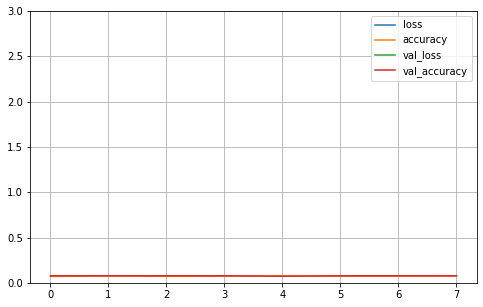

In [16]:
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0,3)
plt.show()

In [7]:

# LOAD BEST MODEL
model = keras.models.load_model('./Health_Diseased_Results/transfer learning/best_train_test_valid_tl_rot_HD.h5')

batch_num=0
predictions = np.array([])
labels =  np.array([])
print('Batch=', end='')
for x, y in test_gen:
  predictions = np.concatenate([predictions, np.argmax(model.predict(x,verbose = 0), axis = -1)])
  labels = np.concatenate([labels, np.argmax(y, axis=-1)])
  batch_num+=1
  print(batch_num,end='...')
  
  if (batch_num>116):
    break

print('\n Checking sizes match:',len(predictions), len(labels))
tf.math.confusion_matrix(labels=labels, predictions=predictions).numpy()
cm = confusion_matrix(labels, predictions)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
cm.diagonal()
acc_each_class = cm.diagonal()

print('accuracy of each class: \n')
with open('./Health_Diseased_Results/transfer learning/RGB_rot_tl_HD.txt', 'w') as f:
  f.write('TEST RESULTS:\n\nRGB Test accuracy:'+str(accuracy_score(labels, predictions))+'\n\n\nAccuracy per class:\n\n')
  for i in range(len(list(valid_gen.class_indices.keys()))):
    print(list(test_gen.class_indices.keys())[i], ' : ', acc_each_class[i])
    f.write('\n'+str(list(valid_gen.class_indices.keys())[i])+ ' : '+ str(acc_each_class[i]))
  print('\n')
  print('Test accuracy:',accuracy_score(labels, predictions))

Batch=1...2...3...4...5...6...7...8...9...10...11...12...13...14...15...16...17...18...19...20...21...22...23...24...25...26...27...28...29...30...31...32...33...34...35...36...37...38...39...40...41...42...43...44...45...46...47...48...49...50...51...52...53...54...55...56...57...58...59...60...61...62...63...64...65...66...67...68...69...70...71...72...73...74...75...76...77...78...79...80...81...82...83...84...85...86...87...88...89...90...91...92...93...94...95...96...97...98...99...100...101...102...103...104...105...106...107...108...109...110...111...112...113...114...115...116...117...
 Checking sizes match: 468 468
accuracy of each class: 

Alstonia Scholaris Diseased  :  0.0
Alstonia Scholaris Healthy  :  0.0
Arjun Diseased  :  0.0
Arjun Healthy  :  0.0
Bael Diseased  :  0.0
Basil Healthy  :  0.0
Chinar Diseased  :  0.0
Chinar Healthy  :  0.0
Gauva Diseased  :  0.0
Gauva Healthy  :  0.0
Jamun Diseased  :  1.0
Jamun Healthy  :  0.0
Jatropha Diseased  :  0.0
Jatropha Healthy  :

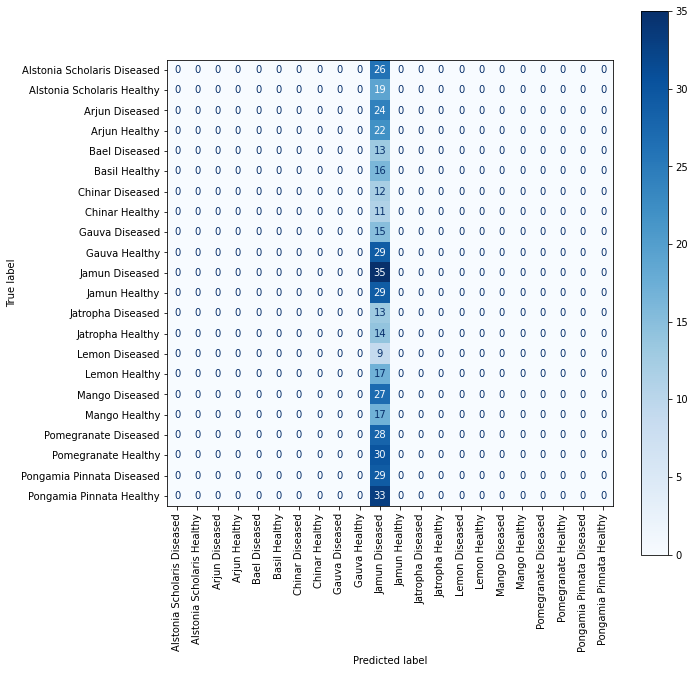

In [8]:
cm = confusion_matrix(labels, predictions)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(test_gen.class_indices.keys()))

fig, ax = plt.subplots(figsize=(10,10))
disp.plot(ax=ax, cmap=plt.cm.Blues, xticks_rotation='vertical')

plt.show()

In [9]:
# CLEAR THE SESSION TO START A NEW ONE
K.clear_session()
del model

# TRYING GRAYSCALE FEATURES

DATA
______

1. The log of train accuracy, train loss, validation accuracy, validation loss can be found in [this log file](./Health_Diseased_Results/transfer%20learning/gray_results_tf.log) 

2. The best model can be loaded from [this model file](./Health_Diseased_Results/transfer%20learning/best_gray_tf.h5) 

3. The test results for the best model can be found in [this text file](./Health_Diseased_Results/transfer%20learning/gray_results.txt) 

In [4]:
def to_grayscale(image):
    image = tf.image.rgb_to_grayscale(image)
    return image

In [5]:
all_data_gen=ImageDataGenerator(rescale=1./155, preprocessing_function = to_grayscale)

# there is a 70-30 training, validation split on the data
# this is without rotation invariance etc
# we rescale our rgb values to flot values

img_height=150
img_width= 150
batch_size=2
train_gen=all_data_gen.flow_from_directory(trainDir,target_size=(img_height, img_width), batch_size=6, class_mode='categorical')
valid_gen=all_data_gen.flow_from_directory(validDir,target_size=(img_height, img_width), batch_size=11, class_mode='categorical')
test_gen=all_data_gen.flow_from_directory(testDir,target_size=(img_height, img_width), batch_size=4, class_mode='categorical')

# LATER FOR MODEL BUILDING:
# https://stackoverflow.com/questions/42443936/keras-split-train-test-set-when-using-imagedatagenerator

Found 3594 images belonging to 22 classes.
Found 440 images belonging to 22 classes.
Found 468 images belonging to 22 classes.


In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [9]:
# save the best model only where HD= Healthy Diseased
earlyStopping=keras.callbacks.EarlyStopping(monitor='val_loss', patience=2)
checkpt=keras.callbacks.ModelCheckpoint("./Health_Diseased_Results/transfer learning/best_gray_tf.h5",monitor='val_loss',  save_best_only=True)
csv_logger = CSVLogger("./Health_Diseased_Results/transfer learning/gray_results_tf.log", separator=',', append=True)

In [10]:
history=model.fit(train_gen, steps_per_epoch=599, epochs=20, validation_data=valid_gen, validation_steps=40, callbacks=[csv_logger,earlyStopping,checkpt])

Epoch 1/20
599/599 [==============================] - 1340s 2s/step - loss: 3.1555 - accuracy: 0.0735 - val_loss: 3.0253 - val_accuracy: 0.0773
Epoch 2/20
599/599 [==============================] - 1283s 2s/step - loss: 3.0236 - accuracy: 0.0760 - val_loss: 3.0149 - val_accuracy: 0.0773
Epoch 3/20
599/599 [==============================] - 1276s 2s/step - loss: 3.0218 - accuracy: 0.0737 - val_loss: 3.0148 - val_accuracy: 0.0773
Epoch 4/20
599/599 [==============================] - 1288s 2s/step - loss: 3.0222 - accuracy: 0.0751 - val_loss: 3.0150 - val_accuracy: 0.0773
Epoch 5/20
599/599 [==============================] - 1286s 2s/step - loss: 3.0215 - accuracy: 0.0754 - val_loss: 3.0143 - val_accuracy: 0.0773
Epoch 6/20
599/599 [==============================] - 1278s 2s/step - loss: 3.0212 - accuracy: 0.0765 - val_loss: 3.0148 - val_accuracy: 0.0727
Epoch 7/20
599/599 [==============================] - 1290s 2s/step - loss: 3.0215 - accuracy: 0.0732 - val_loss: 3.0149 - val_accuracy:

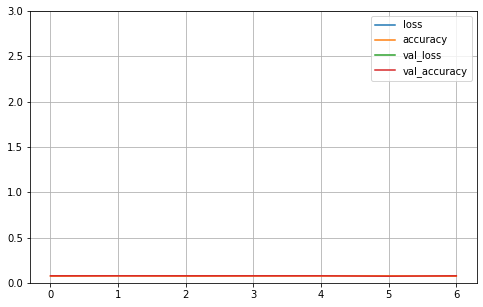

In [11]:
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0,3)
plt.show()

In [8]:
# LOAD BEST MODEL

model = keras.models.load_model('./Health_Diseased_Results/transfer learning/best_gray_tf.h5')

# ===============================================================
# GET TEST MODEL PREDICTIONS
# ===============================================================
# loop through the test set
batch_num=0
predictions = np.array([])
labels =  np.array([])
print('Batch=', end='')
for x, y in test_gen:
  predictions = np.concatenate([predictions, np.argmax(model.predict(x,verbose = 0), axis = -1)])
  labels = np.concatenate([labels, np.argmax(y, axis=-1)])
  batch_num+=1
  print(batch_num,end='...')
   # ensure we don't repeat the samples when checking accuracy and stop at the right batch 
  if (batch_num>116):
    break

# =============================================================
# GET ACCURACY PER CLASS
# =============================================================

# get the confusion matrix in order to calculate the accuracy per class
print('\n Checking sizes match:',len(predictions), len(labels))
tf.math.confusion_matrix(labels=labels, predictions=predictions).numpy()
cm = confusion_matrix(labels, predictions)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
cm.diagonal()
acc_each_class = cm.diagonal()



# =============================================================
# WRITE TO TEXT FILE 
# =============================================================
print('accuracy of each class: \n')
with open('./Health_Diseased_Results/transfer learning/gray_results.txt', 'w') as f:
  f.write('TEST RESULTS:\n\nGrayscale Test accuracy:'+str(accuracy_score(labels, predictions))+'\n\n\nAccuracy per class:\n\n')
  for i in range(len(list(valid_gen.class_indices.keys()))):
    print(list(test_gen.class_indices.keys())[i], ' : ', acc_each_class[i])
    f.write('\n'+str(list(valid_gen.class_indices.keys())[i])+ ' : '+ str(acc_each_class[i]))
  print('\n')
  print('Test accuracy:',accuracy_score(labels, predictions))

Batch=1...2...3...4...5...6...7...8...9...10...11...12...13...14...15...16...17...18...19...20...21...22...23...24...25...26...27...28...29...30...31...32...33...34...35...36...37...38...39...40...41...42...43...44...45...46...47...48...49...50...51...52...53...54...55...56...57...58...59...60...61...62...63...64...65...66...67...68...69...70...71...72...73...74...75...76...77...78...79...80...81...82...83...84...85...86...87...88...89...90...91...92...93...94...95...96...97...98...99...100...101...102...103...104...105...106...107...108...109...110...111...112...113...114...115...116...117...
 Checking sizes match: 468 468
accuracy of each class: 

Alstonia Scholaris Diseased  :  0.0
Alstonia Scholaris Healthy  :  0.0
Arjun Diseased  :  0.0
Arjun Healthy  :  0.0
Bael Diseased  :  0.0
Basil Healthy  :  0.0
Chinar Diseased  :  0.0
Chinar Healthy  :  0.0
Gauva Diseased  :  0.0
Gauva Healthy  :  0.0
Jamun Diseased  :  1.0
Jamun Healthy  :  0.0
Jatropha Diseased  :  0.0
Jatropha Healthy  :

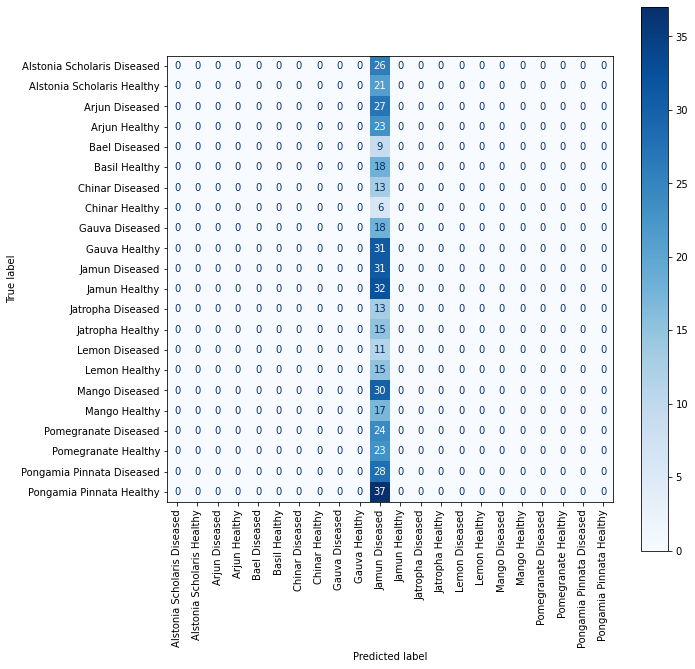

In [9]:
cm = confusion_matrix(labels, predictions)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(test_gen.class_indices.keys()))

fig, ax = plt.subplots(figsize=(10,10))
disp.plot(ax=ax, cmap=plt.cm.Blues, xticks_rotation='vertical')

plt.show()

In [10]:
# CLEAR THE SESSION TO START A NEW ONE
K.clear_session()
del model